## The project's objectives include conducting exploratory data analysis, understanding the distribution of content types across various countries and exploring content clustering using text-based features. Additionally, it includes the development of a recommendation system to enhance user experiences by suggesting related movies and TV shows.

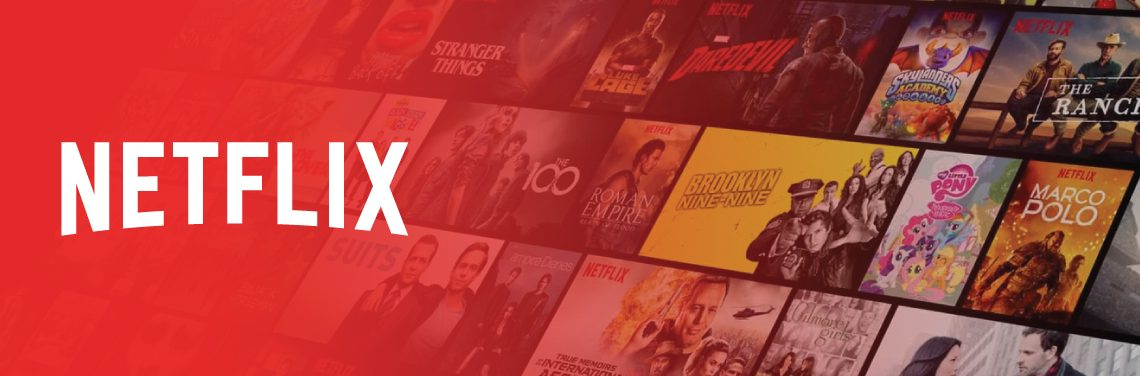

In [6]:
image = Image(filename=r'C:\Users\Windows 10\Downloads\netflix.jpg')
display(image)

**Description of the data fields**

- **show_id**: Unique ID for every Movie or TV Show.
- **type**: The category of content, either "Movie" or "TV Show."
- **title**: The title of the movie or show.
- **director**: The director of the show or movie.
- **cast**: The actors involved in the production.
- **Country**: The country where the content was produced.
- **date_added**: The date when the content was added on Netflix.
- **release_year**: The actual release year of the show or movie.
- **rating**: The TV rating assigned to the show.
- **duration**: The total duration in minutes or the number of seasons for TV shows.
- **listed_in**: The genre or category of the content.
- **description**: A summary description of the show or movie.

### This is a clustering task, where the goal is to analyze and cluster Netflix TV shows and movies based on their text-based features.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd

# Plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image
import plotly.graph_objects as go

# Additional Imports
from matplotlib.figure import Figure
import plotly.offline as py
import plotly.express as px
from datetime import datetime as dt

from wordcloud import WordCloud, STOPWORDS
import nltk,re, string, unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Clustering and Text Processing
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.metrics.pairwise import cosine_similarity

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the dataset and performing basic checks

In [2]:
# Reading the dataset
df=pd.read_csv("C:\\Users\\Windows 10\\Downloads\\NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")

In [3]:
df.sample(6)

show_id     type                        title                  director  \
4235   s4236    Movie                        Mosul  Matthew Michael Carnahan   
2243   s2244    Movie         Forgive Us Our Debts          Antonio Morabito   
6045   s6046  TV Show  That Winter, the Wind Blows                       NaN   
1844   s1845  TV Show                      Dracula                       NaN   
1089   s1090  TV Show                 Breaking Bad                       NaN   
754     s755    Movie         Barrio Universitario             Esteban Vidal   

                                                   cast  \
4235  Suhail Dabbach, Adam Bessa, Is'haq Elias, Quta...   
2243  Marco Giallini, Claudio Santamaria, Jerzy Stuh...   
6045  Zo In-sung, Song Hye-kyo, Kim Bum, Jung Eun-ji...   
1844            Claes Bang, Dolly Wells, John Heffernan   
1089  Bryan Cranston, Aaron Paul, Anna Gunn, Dean No...   
754   Fabrizio Copano, Rodrigo Salinas, Pedro Rumino...   

                                  country         date_added  release_year  \
4235                        United States  November 26, 2020          2020   
2243  Italy, Switzerland, Albania, Poland        May 4, 2018          2018   
6045                          South Korea      April 1, 2019          2013   
1844                       United Kingdom    January 4, 2020          2020   
1089                        United States     August 2, 2013          2013   
754                                 Chile    August 19, 2018          2013   

     rating   duration                                          listed_in  \
4235  TV-MA    103 min   Action & Adventure, Dramas, International Movies   
2243  TV-MA    105 min                       Dramas, International Movies   
6045  TV-MA   1 Season  International TV Shows, Korean TV Shows, Roman...   
1844  TV-14   1 Season  British TV Shows, International TV Shows, TV D...   
1089  TV-MA  5 Seasons            Crime TV Shows, TV Dramas, TV Thrillers   
754   TV-14     91 min                     Comedies, International Movies   

                                            description  
4235  After his life is saved by a rogue Iraqi squad...  
2243  Threatened by creditors, a newly unemployed ma...  
6045  Seeing the chance to enrich himself by deceivi...  
1844  The Count Dracula legend transforms with new t...  
1089  A high school chemistry teacher dying of cance...  
754   Four friends from a humble technical school co...

In [4]:
df.shape

(7787, 12)

In [ ]:
df.info()

In [6]:
# Check basic descriptive statistics
df.describe()

release_year
count   7787.000000
mean    2013.932580
std        8.757395
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2018.000000
max     2021.000000

In [7]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print(missing_values)

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64


- 1: Null values are present in the director, cast, country, date_added and rating columns.

In [9]:
# Filling missing values in the 'director' column with 'Unknown' to indicate unknown director information.
df['director'].fillna("Unknown", inplace=True)

# Filling missing values in the 'cast' column with 'No cast' to indicate no cast information.
df['cast'].fillna(value='No cast', inplace=True)

# Filling missing values in the 'country' column with the mode (most frequent country) to maintain data integrity.
df['country'].fillna(value=df['country'].mode()[0], inplace=True)

df['rating'].fillna(value=df['rating'].mode()[0], inplace=True)


df.dropna(subset=['date_added'], inplace=True)

In [10]:
# Data
labels = ['TV Show', 'Movie']
values = [df.type.value_counts()[1], df.type.value_counts()[0]]

# Colors
colors = ['#ffd700', '#008000']

# Create pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.6)])

# Customize layout
fig.update_layout(
    title_text='Type of Content Watched on Netflix',
    title_x=0.5,
    height=500,
    width=500,
    legend=dict(x=0.9),
    annotations=[dict(text='Type of Content', font_size=20, showarrow=False)]
)

# Set colors
fig.update_traces(marker=dict(colors=colors))

### Majority of content watched on Netflix is movies (69.1%). TV shows account for the remaining 30.9%.

In [12]:
# Convert the 'date_added' to a datetime object
df['date_added'] = pd.to_datetime(df['date_added'])
df['date_added']

0      2020-08-14
1      2016-12-23
2      2018-12-20
3      2017-11-16
4      2020-01-01
          ...    
7782   2020-10-19
7783   2019-03-02
7784   2020-09-25
7785   2020-10-31
7786   2020-03-01
Name: date_added, Length: 7777, dtype: datetime64[ns]

In [13]:
# Extract relevant date features
df['added_year'] = df['date_added'].dt.year
df['added_month'] = df['date_added'].dt.month

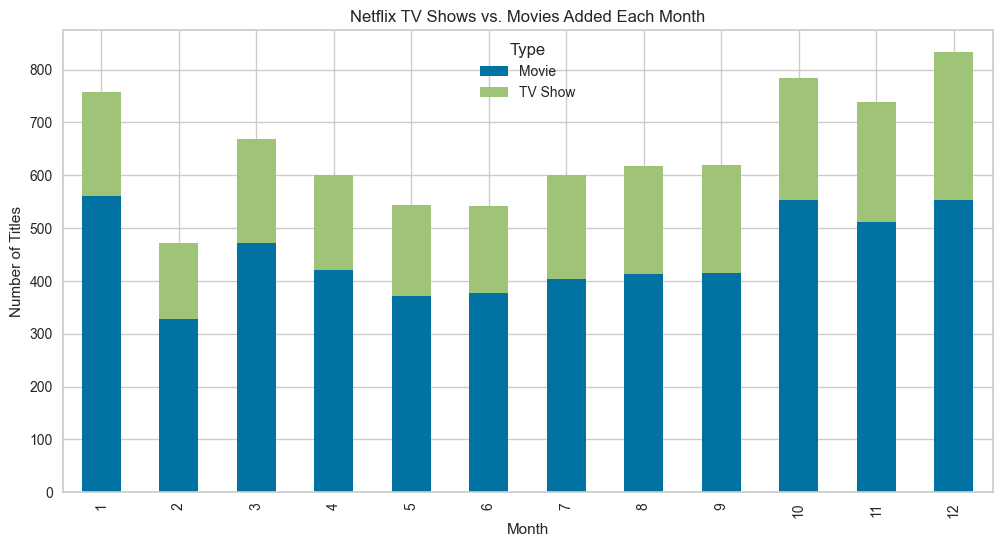

In [14]:
# Group the data by added_month and type (TV show or Movie) and count the occurrences
monthly_counts = df.groupby(['added_month', 'type']).size().unstack().fillna(0)

# Create a bar chart
monthly_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize the plot
plt.title("Netflix TV Shows vs. Movies Added Each Month")
plt.xlabel("Month")
plt.ylabel("Number of Titles")
plt.legend(title="Type", labels=["Movie", "TV Show"])
plt.show()

### Netflix adds more movies and TV shows in January, October, and December than in other months.

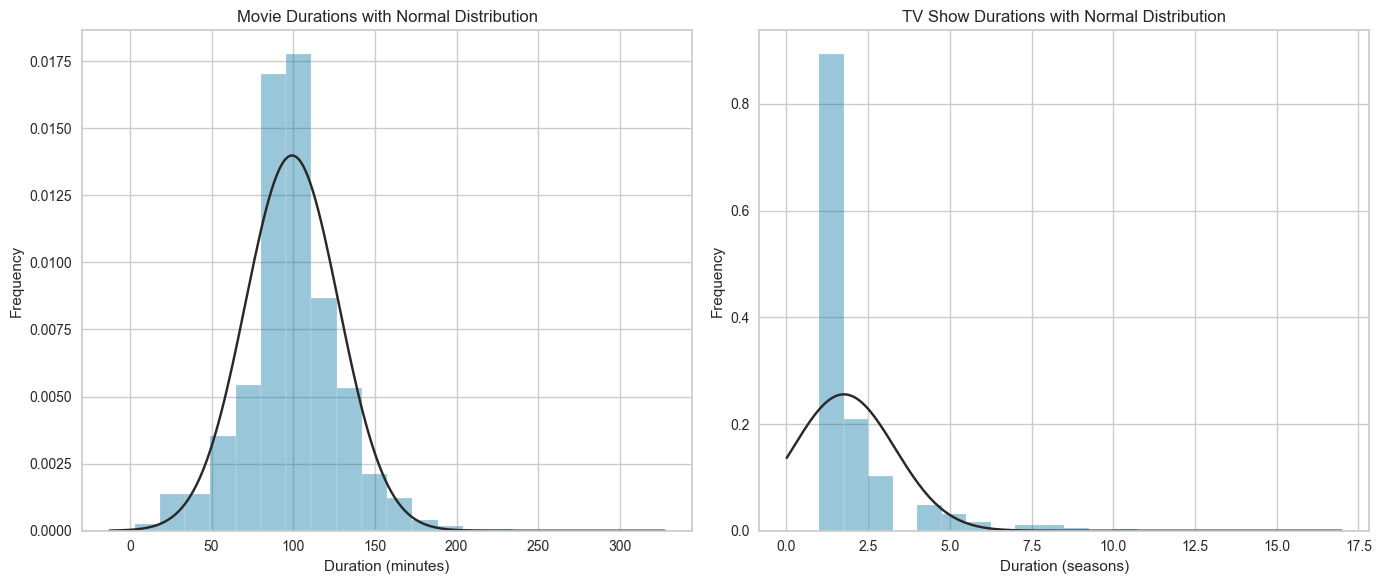

In [15]:
from scipy.stats import norm

# Create subplots for movie and TV show durations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Filter data by type (Movie or TV Show)
movies_data = df[df['type'] == 'Movie']
tv_shows_data = df[df['type'] == 'TV Show']

# Extract the numeric part of the duration column as integers for movies
movies_data['duration'] = movies_data['duration'].str.extract('(\d+)').astype(float)

# Create distplot with normal distribution for movie durations
sns.set_style("whitegrid")
sns.distplot(movies_data['duration'], fit=norm, kde=False, bins=20, ax=axes[0])
axes[0].set_title("Movie Durations with Normal Distribution")
axes[0].set_xlabel("Duration (minutes)")
axes[0].set_ylabel("Frequency")

# Extract the numeric part of the duration column as integers for TV shows
tv_shows_data['duration'] = tv_shows_data['duration'].str.extract('(\d+)').astype(float)

# Create distplot with normal distribution for TV show durations
sns.set_style("whitegrid")
sns.distplot(tv_shows_data['duration'], fit=norm, kde=False, bins=20, ax=axes[1])
axes[1].set_title("TV Show Durations with Normal Distribution")
axes[1].set_xlabel("Duration (seasons)")
axes[1].set_ylabel("Frequency")

# Show the plots
plt.tight_layout()
plt.show()

In [16]:
country_count=df['country'].value_counts().sort_values(ascending=False)
country_count=pd.DataFrame(country_count)
topcountries=country_count[0:11]
topcountries

country
United States      3055
India               923
United Kingdom      396
Japan               225
South Korea         183
Canada              177
Spain               134
France              115
Egypt               101
Turkey              100
Mexico              100

In [17]:
import plotly.graph_objects as go

# Top 10 countries by number of movies
topcountries = country_count.head(10)

# Create a Funnel Chart
fig = go.Figure(go.Funnel(
    y=topcountries.index,
    x=topcountries['country'],
    textinfo="value",
    marker={"color": "#0a73d4"}
))

# Update the layout and title
fig.update_layout(
    title="Funnel Chart - Top 10 Countries by Number of Movies",
    xaxis_title="Number of Movies",
    yaxis_title="Country",
    xaxis={"showgrid": False},
    yaxis={"showgrid": False},
)

# Show the chart
fig.show()

### The United States leads with 3055 movies, asserting its dominance in the film industry. India follows with 923 movies, showcasing a strong presence in the global entertainment market.

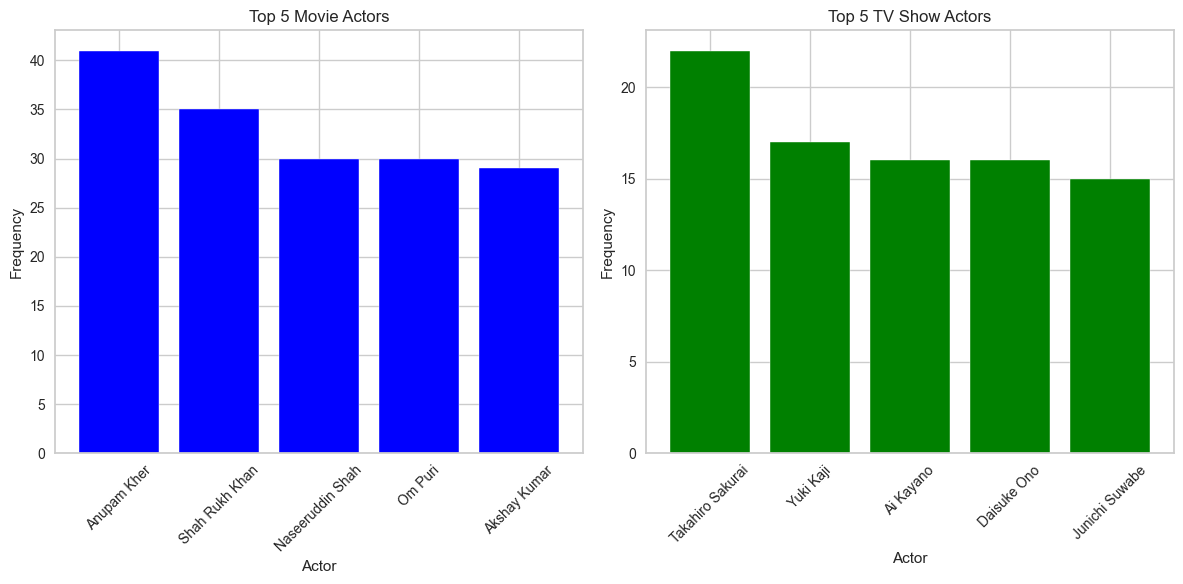

In [18]:
# Filter data by type (Movie or TV Show)
movie_data = df[df['type'] == 'Movie']
tv_show_data = df[df['type'] == 'TV Show']

# Get the top 5 actors in movies and TV shows, excluding "No cast"
top_actors_movies = movie_data['cast'].str.split(', ').explode().value_counts().drop("No cast").head(5)
top_actors_tv_shows = tv_show_data['cast'].str.split(', ').explode().value_counts().drop("No cast").head(5)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot top 5 movie actors
ax1.bar(top_actors_movies.index, top_actors_movies.values, color='blue')
ax1.set_title('Top 5 Movie Actors')
ax1.set_xlabel('Actor')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='x', rotation=45)

# Plot top 5 TV show actors
ax2.bar(top_actors_tv_shows.index, top_actors_tv_shows.values, color='green')
ax2.set_title('Top 5 TV Show Actors')
ax2.set_xlabel('Actor')
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### The top actors are from India and South Korea , suggesting that there is a strong demand for content from these countries.

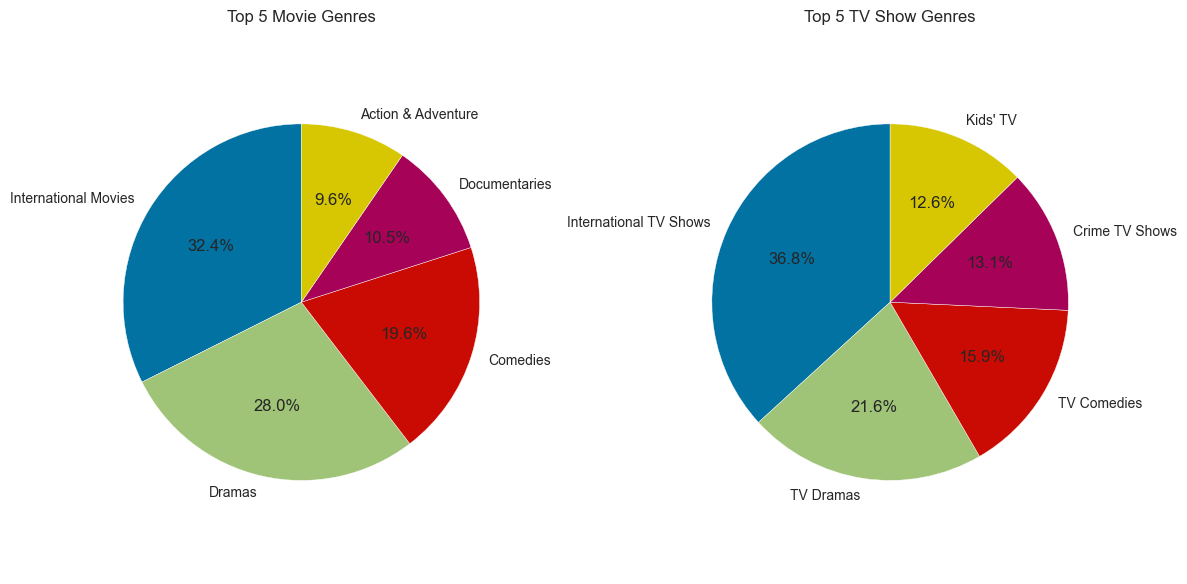

In [20]:
# Filter data by type (Movie or TV Show)
movie_data = df[df['type'] == 'Movie']
tv_show_data = df[df['type'] == 'TV Show']

# Get the genre counts for movies and TV shows
genre_counts_movies = movie_data['listed_in'].str.split(', ').explode().value_counts()
genre_counts_tv_shows = tv_show_data['listed_in'].str.split(', ').explode().value_counts()

# Get the top 5 genres for movies and TV shows
top_genres_movies = genre_counts_movies.head(5)
top_genres_tv_shows = genre_counts_tv_shows.head(5)

# Create pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for top 5 movie genres
ax1.pie(top_genres_movies, labels=top_genres_movies.index, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
ax1.set_title('Top 5 Movie Genres')

# Pie chart for top 5 TV show genres
ax2.pie(top_genres_tv_shows, labels=top_genres_tv_shows.index, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
ax2.set_title('Top 5 TV Show Genres')

# Show the pie charts
plt.tight_layout()
plt.show()

### Internationally produced content is the most popular genre for both movies and TV shows.

In [21]:
# Extract the release year from the 'release_year' column as integers
df['release_year'] = df['release_year'].astype(int)

# Filter data for the last 10 years
recent_data = df[df['release_year'] >= df['release_year'].max() - 10]

# Group the data by release year and count the number of releases
yearly_counts = recent_data['release_year'].value_counts().sort_index().reset_index()
yearly_counts.columns = ['Year', 'Number of Releases']

# Create a bar plot using Plotly
fig = px.bar(
    yearly_counts,
    x='Year',
    y='Number of Releases',
    title="Total Releases for the Last 10 Years",
    labels={'Year': 'Year', 'Number of Releases': 'Number of Releases'},
)

fig.update_traces(marker_color='blue')
fig.update_xaxes(type='category',tickangle=45)
fig.update_layout(showlegend=False)
fig.show()

### 2018 was the year with the most releases.

In [22]:
# Define a mapping of content ratings to age groups or audiences
rating_map = {'TV-MA':'Adults',
              'R':'Adults',
              'PG-13':'Teens',
              'TV-14':'Young Adults',
              'TV-PG':'Older Kids',
              'NR':'Adults',
              'TV-G':'Kids',
              'TV-Y':'Kids',
              'TV-Y7':'Older Kids',
              'PG':'Older Kids',
              'G':'Kids',
              'NC-17':'Adults',
              'TV-Y7-FV':'Older Kids',
              'UR':'Adults'}

# Replace the original content ratings in the 'rating' column with the corresponding age group or audience labels
df['rating'].replace(rating_map, inplace=True)

# Display the unique values in the 'rating' column to verify the replacement
df['rating'].unique()

array(['Adults', 'Teens', 'Young Adults', 'Older Kids', 'Kids'],
      dtype=object)

Text(0.5, 1.0, 'Number of shows on Netflix for different age groups')

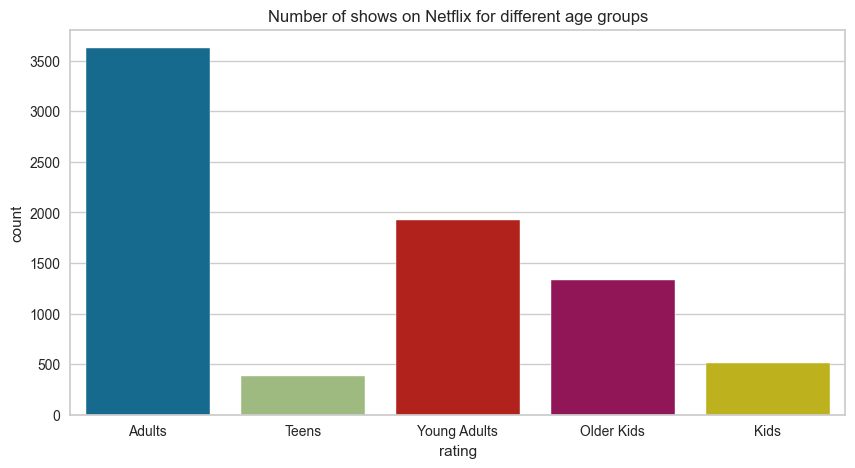

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)
plt.title('Number of shows on Netflix for different age groups')

### The number of shows for Adults is almost double the number of shows for Young Adults.

## Creating a WordCloud to Visualize the Most Common Words in Text Descriptions

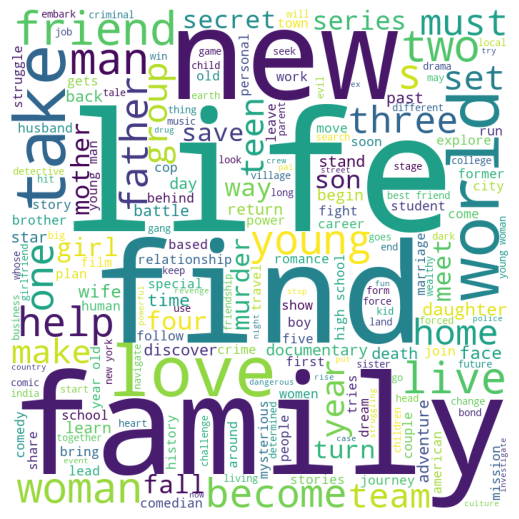

In [24]:
# Initialize an empty string to store words from descriptions
comment_words = ''

# Create a set of stopwords for filtering common words
stopwords = set(STOPWORDS)

# Iterate through the 'description' values in the DataFrame
for val in df.description.values:    
    # Convert the description to a string
    val = str(val)
    # Tokenize the description by splitting it into words
    tokens = val.split()
    # Convert each word to lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    # Join the processed tokens into the comment_words string
    comment_words += " ".join(tokens)+" "

# Create a WordCloud
wordcloud = WordCloud(width=700, height=700,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)

# Display the WordCloud
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

### The graph reveals that the words life, family, love, friend, world, new, and find appear frequently.

### Key Findings

- **Content on Netflix**: Movies make up 69.1%, TV shows 30.9%.
- **Seasonal Trends**: Peaks in content addition in January, October, and December.
- **Duration Analysis**: Different distributions for movie durations and TV show seasons.
- **Content Origin**: The US and India dominate content production.
- **Top Actors and Genres**: Identified for movies and TV shows.
- **Content Description**: Common words like "life," "family," "love" in descriptions.

### Data Preprocessing

In [25]:
# Create a new column 'clustering' by combining selected columns with spaces
df['clustering'] = (df['director'] + ' ' + 
                        df['cast'] +' ' + 
                        df['country'] +' ' + 
                        df['listed_in'] +' ' + 
                        df['description'])

In [26]:
# Display a sample data point
df['clustering'][100]

"Rajkumar Hirani Aamir Khan, Kareena Kapoor, Madhavan, Sharman Joshi, Omi Vaidya, Boman Irani, Mona Singh, Javed Jaffrey India Comedies, Dramas, International Movies While attending one of India's premier colleges, three miserable engineering students and best friends struggle to beat the school's draconian system."

### **Removing Punctuation**

In [27]:
# Defining a function for removing punctuation from text
def remove_punctuation(text):
    '''A function for removing punctuation'''
    # Create a translation table to remove punctuation characters
    translator = str.maketrans('', '', string.punctuation)
    # Use the translation table to remove punctuation from the input text
    return text.translate(translator)

In [28]:
# Removing punctuation marks
df['clustering'] = df['clustering'].apply(remove_punctuation)

### **Removing non-ASCII characters**

In [29]:
# Defining a function to remove non-ASCII characters from a list of words
def remove_non_ascii(words):
    """Function to remove non-ASCII characters"""
    new_words = []
    for word in words:
        # Use the 'unicodedata' library to normalize and remove non-ASCII characters
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [30]:
# Removing non-ascii characters
df['clustering'] = remove_non_ascii(df['clustering'])

### **Removing stopwords**

In [31]:
# Retrieve the list of stopwords in English
sentences = stopwords.words('english')

# Convert the list of stopwords to a NumPy array
np.array(sentences)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [32]:
# Defining a function to remove stop words
def remove_stopwords(text):
    '''A function for removing the stopwords'''
    # Split the input text into words and convert them to lowercase
    # while excluding words found in the 'sentences' list (stopwords)
    text = [word.lower() for word in text.split() if word.lower() not in sentences]
    # Join the list of words with a space separator and return the result
    return " ".join(text)

In [33]:
# Removing stop words
df['clustering'] = df['clustering'].apply(remove_stopwords)

### *Tokenization*

In [34]:
tokenizer = TweetTokenizer()
df['clustering'] = df['clustering'].apply(lambda x: tokenizer.tokenize(x))

In [35]:
df['clustering'][100]

['rajkumar',
 'hirani',
 'aamir',
 'khan',
 'kareena',
 'kapoor',
 'madhavan',
 'sharman',
 'joshi',
 'omi',
 'vaidya',
 'boman',
 'irani',
 'mona',
 'singh',
 'javed',
 'jaffrey',
 'india',
 'comedies',
 'dramas',
 'international',
 'movies',
 'attending',
 'one',
 'indias',
 'premier',
 'colleges',
 'three',
 'miserable',
 'engineering',
 'students',
 'best',
 'friends',
 'struggle',
 'beat',
 'schools',
 'draconian',
 'system']

### **Lemmatization**

In [36]:
# Instantiate a lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return lemmatized_tokens

# Apply lemmatization to the 'clustering' column after tokenization
df['clustering'] = df['clustering'].apply(lemmatize_tokens)

### **Vectorization**


In [37]:
# Join the list of tokens into a single string for each row
df['clustering'] = df['clustering'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20000)

# Fit and transform the 'clustering' column to create TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(df['clustering'])

# Convert the TF-IDF vectors to a DataFrame
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Now, tfidf_df contains the TF-IDF vectors for the text data in the 'clustering' column.

In [38]:
tfidf_df.shape

(7777, 20000)

In [39]:
# convert X into array form for clustering
X = tfidf_df.values

In [40]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Principal Component Analysis (PCA) for Dimensionality Reduction

In [41]:
# Initialize PCA
pca = PCA(random_state=40)
# Fit PCA to the data
pca.fit(X)

PCA(random_state=40)

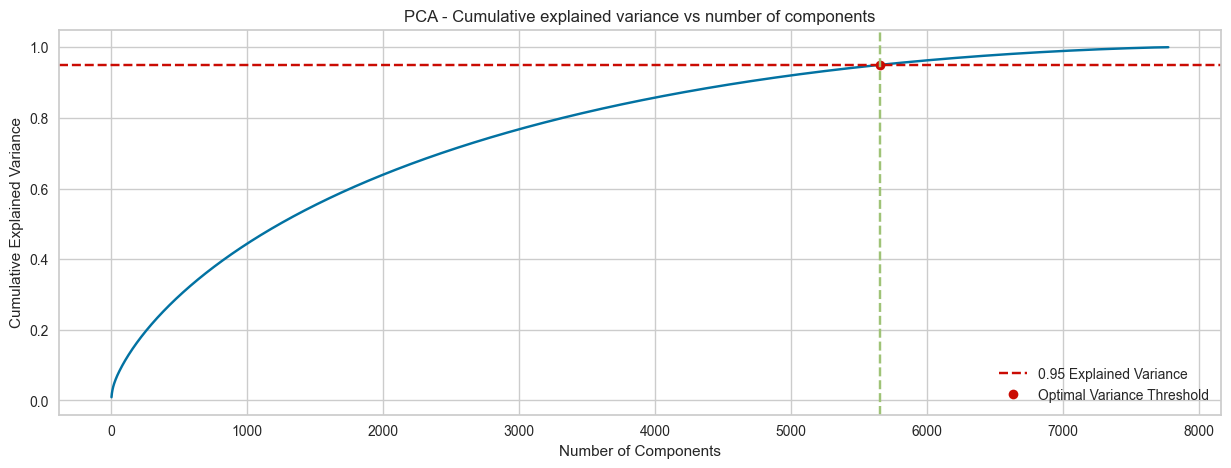

Optimal number of components: 5654


In [42]:
# Explained variance for different number of components
plt.figure(figsize=(15, 5))
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance)
plt.title('PCA - Cumulative explained variance vs number of components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# Draw a line at 0.95 cumulative explained variance
plt.axhline(y=0.95, color='r', linestyle='--', label='0.95 Explained Variance')
plt.legend()

# Find the 'Optimal Variance Threshold' point where explained variance starts to saturate
variance_threshold_index = next(i for i, ev in enumerate(explained_variance) if ev >= 0.95)

# Mark the 'Optimal Variance Threshold' point with a red dot
plt.plot(variance_threshold_index, explained_variance[variance_threshold_index], 'ro', label='Optimal Variance Threshold')
plt.legend()

# Draw a vertical line at the 'Optimal Variance Threshold' point
plt.axvline(x=variance_threshold_index, color='g', linestyle='--')
plt.legend()

plt.show()

# The 'Optimal Variance Threshold' indicates the optimal number of components to retain
print(f"Optimal number of components: {variance_threshold_index + 1}")

**The plot helps in determining the number of components to consider for dimensionality reduction. You can select the number of components where the cumulative explained variance reaches a satisfactory threshold, such as 95%. The point where the curve intersects or is closest to the threshold line can guide you in choosing the appropriate number of components for your analysis.**

In [43]:
# Initialize PCA with the desired explained variance
pca_tuned = PCA(n_components=0.95)

# Fit the PCA model on the input data, X
pca_tuned.fit(X)

# Transform the input data, X, to its reduced dimensional representation
X_transformed = pca_tuned.transform(X)

## Implementing Models

### KMeans Clustering

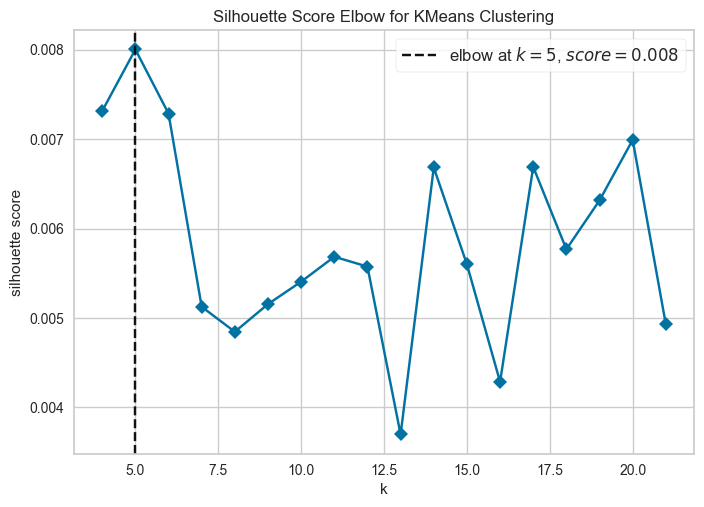

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [48]:
# Initialize the KMeans model with a random_state of 5
model = KMeans(random_state=5)

# Initialize the KElbowVisualizer with the KMeans model and desired parameters
visualizer = KElbowVisualizer(model, k=(4, 22), metric='silhouette', timings=False, locate_elbow=True)

# Fit the visualizer on the transformed data
visualizer.fit(X_transformed)

# Display the elbow plot
visualizer.show()

Cluster Centers:
[[-3.76811597e-02  2.47266497e-02  2.89503053e-02 ...  1.46779540e-05
   9.86375101e-06  2.48832171e-05]
 [-4.77197849e-02 -1.10699927e-03 -3.50916160e-02 ...  4.85820050e-06
  -2.75513960e-06 -6.57777683e-05]
 [ 1.60329735e-01 -4.65702981e-03 -7.38986495e-03 ... -2.14197651e-05
   2.82807645e-05  6.07361441e-06]
 [-3.06796828e-02  9.96966123e-02  1.34274669e-01 ... -2.46765559e-05
   8.32851113e-05  5.94732727e-05]
 [-6.70852348e-02 -9.87015553e-02 -3.68077914e-02 ... -2.36175937e-06
  -1.08316305e-04  5.49181906e-05]]


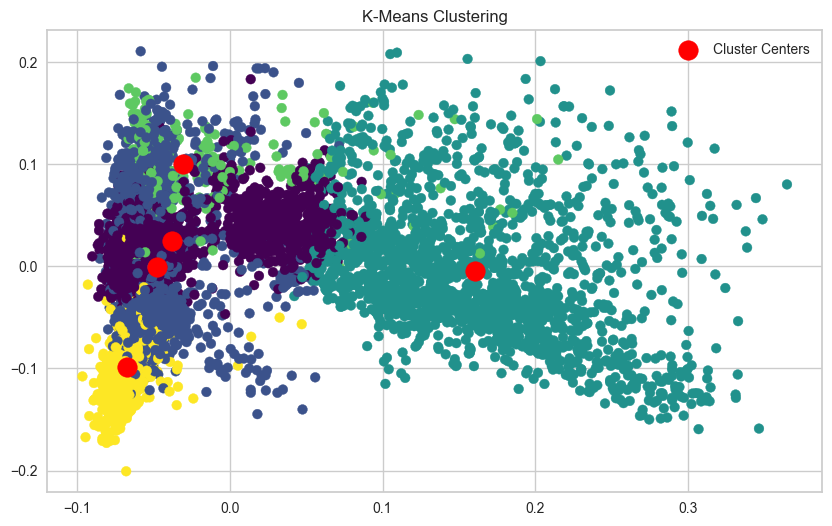

In [49]:
# Choose the number of clusters 
num_clusters = 5

# Initialize the K-Means model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model on your transformed data
kmeans.fit(X_transformed)

# Add the cluster labels to your original DataFrame
df['cluster'] = kmeans.labels_

# Display the cluster centers
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:")
print(cluster_centers)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, label='Cluster Centers')
plt.title("K-Means Clustering")
plt.legend()
plt.show()

In [66]:
# Define the cluster number you want to retrieve movies from
desired_cluster = 4  

# Filter the DataFrame to get movies in the desired cluster
cluster_movies = df[df['cluster'] == desired_cluster]

# Display the movies in the cluster
print(f"Movies in Cluster {desired_cluster}:")
print(cluster_movies[['title', 'cluster']])

Movies in Cluster 4:
                         title  cluster
8                          706        4
9                         1920        4
18                      15-Aug        4
20        ​​Kuch Bheege Alfaaz        4
21                ​Goli Soda 2        4
...                        ...      ...
7768  Zindagi Kitni Haseen Hay        4
7769  Zindagi Na Milegi Dobara        4
7776                  Zokkomon        4
7780                       Zoo        4
7783                    Zubaan        4

[913 rows x 2 columns]


### Hierarchical Agglomerative Clustering

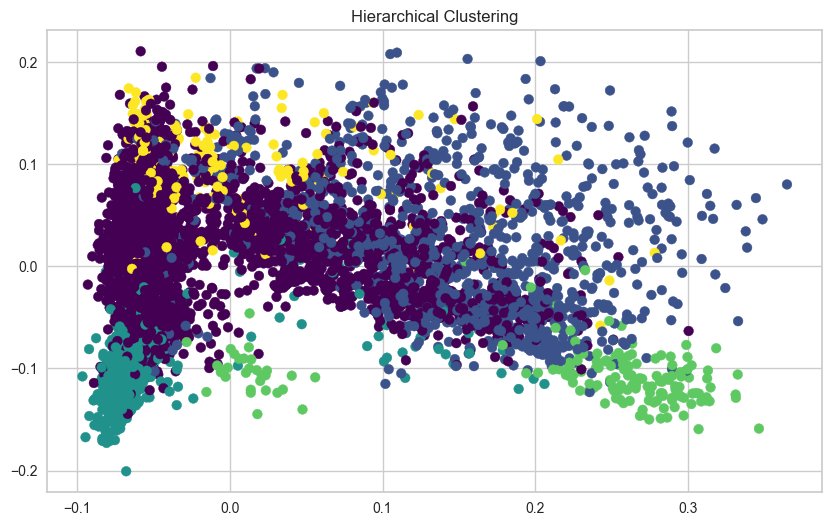

In [50]:
# Choose the number of clusters 
num_clusters = 5

# Initialize the Agglomerative Clustering model
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)

# Fit the model on your transformed data
agg_clustering.fit(X_transformed)

# Add the cluster labels to your original DataFrame
df['cluster_agg'] = agg_clustering.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=agg_clustering.labels_, cmap='viridis')
plt.title("Hierarchical Clustering")
plt.show()

In [67]:
# Sample movie/show title for which you want to make recommendations
sample_title = "Stranger Things"

# Find the index of the sample movie/show in the DataFrame
sample_index = df[df['title'] == sample_title].index[0]

# Calculate the cosine similarity between the sample movie/show and all other movies/shows
cosine_similarities = cosine_similarity(X_transformed[sample_index].reshape(1, -1), X_transformed)

# Get the top 5 similar movies/shows
N = 5  
similar_movies_indices = cosine_similarities.argsort()[0][::-1][1:N+1]

# Extract the titles of the recommended movies/shows
recommended_titles = df.iloc[similar_movies_indices]['title']

# Display the recommended movies/shows
print(f"Recommended Movies/Shows for '{sample_title}':")
for i, title in enumerate(recommended_titles, 1):
    print(f"{i}. {title}")

Recommended Movies/Shows for 'Stranger Things':
1. Stretch Armstrong & the Flex Fighters
2. LEGO Marvel Super Heroes: Black Panther
3. Trollhunters
4. Always a Bridesmaid
5. Chris Brown: Welcome to My Life


#### Future Work

- **Integrating this dataset with external sources such as IMDB ratings can lead to numerous intriguing discoveries.**

- **This system could then be deployed on the web for widespread usage.**